# 1 - Pricing and hedging by Monte Carlo

### 1.1 Finite differences approach

1. Implement a standard Euler-Maruyama approximation to the Heston model. Define a function called ”GeneratePathsHestonEuler()” whose arguments are:
- The model parameters
- The number of paths
- The number of steps 

This function returns a matrix of size (NbofPaths, NbofSteps)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
def GeneratePathsHestonEulerbis(S0, v0, rho, kappa, theta, gamma,T, N, M,r,seed):
    
    """
    S0 : inital asset price
    v0 : initial variance
    rho : correlation between of the two brownian processes
    kappa : rate of mean reversion in variance process
    theta : long run average variance
    gamma : vol of vol 
    T : maturity
    N : number of steps
    M : number of paths
    r : risk free rate

    """
    start = time.time()

    dt = 1/N
    X_total = []
    np.random.seed(seed)
    for j in range(M):
        V=np.zeros(N)
        V[0] = v0
        X = np.zeros(N)
        X[0] = S0
        
        for i in range(1,N):
           
            z1 = np.random.normal(0,1,1)[0]
            z2 = rho * z1 + np.sqrt(1 - rho*rho) *  np.random.normal(0,1,1)[0]

            V[i] = max(V[i-1] + kappa*(theta - V[i-1])*dt + gamma*np.sqrt(V[i-1]*dt)*z2,0)
            X[i] = X[i-1] * np.exp( (r - 0.5*V[i-1])*dt + np.sqrt(V[i-1] * dt) * z1 )
            
        X_total.append(X)
    end = time.time()
    return X_total,end-start

In [ ]:
def GeneratePathsHestonEuler(S0: float, v0: float, risk_free_rate: float, maturity: float, rho: float, kappa: float,
                             theta: float, sigma: float, nb_steps, nb_simuls, seed=1):
    np.random.seed(seed)
    dt = maturity / nb_steps
    mu = np.array([0, 0])
    cov = np.array([[1, rho],
                    [rho, 1]])
    S = np.full(shape=(nb_steps + 1, nb_simuls), fill_value=float(S0))
    v = np.full(shape=(nb_steps + 1, nb_simuls), fill_value=float(v0))
    Z = np.random.multivariate_normal(mu, cov, (nb_steps, nb_simuls))
    for i in range(1, nb_steps + 1):
        S[i] = S[i - 1] * np.exp((risk_free_rate - 0.5 * v[i - 1]) * dt + np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 0])
        v[i] = np.maximum(v[i - 1] + kappa * (theta - v[i - 1]) * dt + sigma * np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 1], 0)
    return S.T

In [ ]:
K = 100
B = 90
v_ = 0.5
kappa = 0.1
sigma_sigma = 0.1
corr_bms = -0.9
r = 0.02
S0 = 100
V0 = 0.1
T=1
seed=123
X_total=GeneratePathsHestonEuler(S0, V0, r, T, corr_bms, kappa,v_, sigma_sigma, 252, 1000, seed=123)


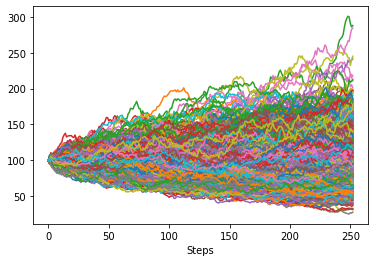

In [ ]:
def plotting_paths(Array_Paths):
  for i in range(len(Array_Paths)): 
    plt.plot(X_total[i])
  plt.xlabel('Steps')
  plt.show()

plotting_paths(X_total)

2. Implement a function ”Payoff” that returns the payoff of the down-and-out barrier call option defined above. This function takes the option parameters and the asset prices in argument and returns the price of the option

The option is exercisable if the price of the underlying has not broken 
the barrier. 

In [ ]:
def Payoff(S,K,B):  # S is a list = one path
    """
    K : strike
    B : barrier
    S : underlying asset (list)
    
    """
    valeur_exercice = max(S[-1] - K, 0)
    if np.min(S) < B:
        payoff = 0
    else:
        payoff = valeur_exercice
    return payoff 

3. Implement a function ”MC Pricing()” which takes the seed, the number of paths, the number
of steps, the model parameters, and the option parameters in argument and return the price of
the option computed by Monte Carlo. This function must call ”GeneratePathsHestonEuler()”
and ”Payoff() ” to ensure code readability.



In [ ]:
def MC_Pricing(N,M,K,B,r,T,S0,v0, rho, kappa, theta, sigma,seed):
    """
    S0 : inital asset price
    v0 : initial variance
    rho : correlation between of the two brownian processes
    kappa : rate of mean reversion in variance process
    theta : long run average variance
    gamma : vol of vol 
    T : maturity
    N : number of steps
    M : number of paths
    r : risk free rate
    K : strike
    B : barrier
    S : underlying asset (list)

    """
    np.random.seed(seed)
    payoffs=[]
    X_total = GeneratePathsHestonEuler(S0, v0,r,T,rho,kappa,theta,sigma,N,M,seed) 
    for i in range(len(X_total)):
        payoffs.append(Payoff(X_total[i,:],K,B))
    return np.mean(payoffs)* np.exp(-r*T)

In [ ]:
MC_Pricing(252,1000,K,B,r,T,100, 0.1, -0.9, 0.1, 0.5, 0.1,seed)

8.993915751571558

4. Implement three functions ”DeltaFD()”, ”GammaFD()”, ”RhoFD()” which estimate the delta, the gamma and the rho of the option by using first order finite differences (i.e. “bumping”).


In [ ]:
h=0.0001 

In [ ]:
def DeltaFD(N,M,K,B,r,T,S0,v0, rho, kappa, theta, sigma,h,seed):
    """
    S0 : inital asset price
    v0 : initial variance
    rho : correlation between of the two brownian processes
    kappa : rate of mean reversion in variance process
    theta : long run average variance
    gamma : vol of vol 
    T : maturity
    N : number of steps
    M : number of paths
    r : risk free rate
    K : strike
    B : barrier
    S : underlying asset (list)
    h : bump size

    """
    X_plus_h = MC_Pricing(N,M,K,B,r,T,(S0+h), 0.1, -0.9, 0.1, 0.5, 0.1,seed)
    X_moins_h = MC_Pricing(N,M,K,B,r,T,(S0-h), 0.1, -0.9, 0.1, 0.5, 0.1,seed)
    delta = (X_plus_h - X_moins_h) /(2*h)

    return delta

In [ ]:
DeltaFD(252,1000,K,B,r,T,100, 0.1, -0.9, 0.1, 0.5, 0.1,h,seed)

0.3104838590228809

In [ ]:
def GammaFD(N,M,K,B,r,T,S0,v0, rho, kappa, theta, sigma,h,seed):
    """
    S0 : inital asset price
    v0 : initial variance
    rho : correlation between of the two brownian processes
    kappa : rate of mean reversion in variance process
    theta : long run average variance
    gamma : vol of vol 
    T : maturity
    N : number of steps
    M : number of paths
    r : risk free rate
    K : strike
    B : barrier
    S : underlying asset (list)
    h : bump size

    """
    # Calcul de la valeur de l'option pour les prix de l'actif S + h, S et S - h
    X_plus_h = MC_Pricing(N,M,K,B,r,T,(S0+h), 0.1, -0.9, 0.1, 0.5, 0.1,seed)
    X_moins_h = MC_Pricing(N,M,K,B,r,T,(S0-h), 0.1, -0.9, 0.1, 0.5, 0.1,seed)
    X = MC_Pricing(N,M,K,B,r,T,S0, 0.1, -0.9, 0.1, 0.5, 0.1,seed)

    # Estimation du gamma en utilisant la méthode des différences finies
    gamma = (X_plus_h + X_moins_h - 2 * X) / (h ** 2)
    return gamma

In [ ]:
GammaFD(252,1000,K,B,r,T,100, 0.1, -0.9, 0.1, 0.5, 0.1,h,seed)

-3.552713678800501e-07

In [ ]:
def RhoFD(N,M,K,B,r,T,S0,v0, rho, kappa, theta, sigma,h,seed):
    """
    S0 : inital asset price
    v0 : initial variance
    rho : correlation between of the two brownian processes
    kappa : rate of mean reversion in variance process
    theta : long run average variance
    gamma : vol of vol 
    T : maturity
    N : number of steps
    M : number of paths
    r : risk free rate
    K : strike
    B : barrier
    S : underlying asset (list)
    h : bump size

    """
    # Calcul de la valeur de l'option pour les taux d'intérêt sans risque r + h et r - h
    X_plus_h = MC_Pricing(N,M,K,B,r+h,T,S0, 0.1, -0.9, 0.1, 0.5, 0.1,seed)
    X_moins_h = MC_Pricing(N,M,K,B,r-h,T,S0, 0.1, -0.9, 0.1, 0.5, 0.1,seed)
    rho = (X_plus_h - X_moins_h) /(2*h)
    return rho/100

In [ ]:
RhoFD(252,1000,K,B,r,T,100, 0.1, -0.9, 0.1, 0.5, 0.1,h,seed)

0.22054470186159136

5. For the three sensitivities, set the number of paths to 10000 and the number of steps to 100. Plot how the variance of the estimator changes with the bump size, and comment on the reasons for this.

In [ ]:
M = 10000
N = 100
h=0.0001 

In [ ]:
def var_estimator():
    var_delta=[]
    var_gamma =[]
    var_rho=[]
    for i in np.linspace(0.01,1,10):
        print(i)
        deltas=[]
        gammas = []
        rhos=[]
        for j in range(1,5):
            deltas.append(DeltaFD(N,M,K,B,r,T,100, 0.1, -0.9, 0.1, 0.5, 0.1,i,j))
            gammas.append(GammaFD(N,M,K,B,r,T,100, 0.1, -0.9, 0.1, 0.5, 0.1,i,j))
            rhos.append(RhoFD(N,M,K,B,r,T,100, 0.1, -0.9, 0.1, 0.5, 0.1,i,j))

        var_delta.append(np.var(deltas))
        var_gamma.append(np.var(gammas))
        var_rho.append(np.var(rhos))

    return var_delta,var_gamma,var_rho

In [ ]:
var_delta,var_gamma,var_rho = var_estimator()

0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0


In [ ]:
def plot_var(values,title):
  plt.plot(np.linspace(0.01,1,10),values)
  plt.xlabel('bump size')
  plt.title(title)
  plt.show()


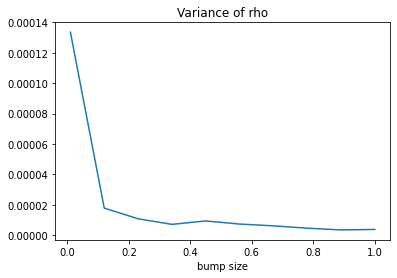

In [ ]:
plot_var(var_rho,'Variance of rho')

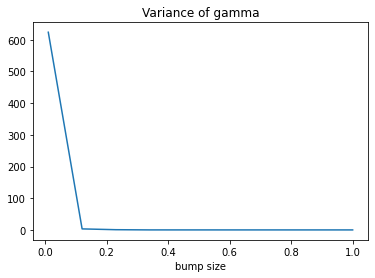

In [ ]:
plot_var(var_gamma,'Variance of gamma')

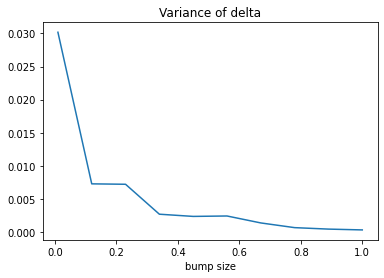

In [ ]:
plot_var(var_delta,'Variance of delta')

6. Implement a function ”StandardError()” which takes the number of paths, and the payoff
vector as arguments and returns the standard error of one pricing by Monte-Carlo. Plot the
95% confidence interval for different values of the number of paths. Interpret the results.


In [ ]:
def StandardError(prices,M): 
    return np.sqrt(np.var(prices)/M) 

In [ ]:
def IC():
  IC_borne_inf =[]
  IC_borne_sup =[]
  for i in range(1,100):
      prices=[]
      for j in range(1,10):
          prices.append(MC_Pricing(N,i,K,B,r,T,100, 0.1, -0.9, 0.1, 0.5, 0.1,j))
      mean_prices = np.mean(prices)
      std_error = StandardError(prices,i)
      IC_borne_inf.append(mean_prices - 1.96*std_error)
      IC_borne_sup.append(mean_prices + 1.96*std_error)
  return IC_borne_inf,IC_borne_sup

In [ ]:
IC_borne_inf,IC_borne_sup = IC()

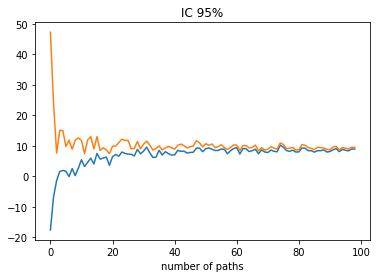

In [ ]:
plt.plot(IC_borne_inf)
plt.plot(IC_borne_sup)
plt.xlabel('number of paths')
plt.title('IC 95%')
plt.show()

### 1.2 Automatic adjoint differentiation approach

In [ ]:
import torch
import numpy as np

# Set the device to run on (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of steps and paths

# Set the model parameters

torch.autograd.set_detect_anomaly(True)
# Convert the model parameters to PyTorch tensors and set requires_grad=True
py_v_ = torch.tensor(0.5, device=device)
py_Kappa = torch.tensor(0.1, device=device)
py_K = torch.tensor(100.0, device=device, requires_grad=True)
py_sigma_sigma = torch.tensor(0.1, device=device)
py_corr_bms = torch.tensor(-0.9, device=device)
py_r = torch.tensor(0.02, device=device, requires_grad=True)
py_S_0 = torch.tensor(100.0, device=device, requires_grad=True)
py_V_0 = torch.tensor(0.1, device=device, requires_grad=True)
py_T= torch.tensor(1.0, device=device)
py_B=torch.tensor(90.0, device=device)

def GeneratePathsHestonEuler_torch(S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=100, seed=123):
    S_total=[]
    torch.manual_seed(seed)
    for i in range(n_paths):
        V = torch.zeros(n_steps, device=device)
        S = torch.zeros(n_steps, device=device)
        V[0] = V0
        S[0] = S0
        dt = T / torch.tensor(n_steps, device=device)

        for i in range(1,n_steps):
            z1 = torch.normal(0,1,[1], device=device)
            z2 =  corr_bms * z1 + np.sqrt(torch.tensor(1.0,device=device) -  corr_bms* corr_bms) *  torch.normal(0,1,[1], device=device)
            V[i] = torch.max(V[i-1].clone() + kappa*(v_ - V[i-1].clone())*dt + sigma_sigma*torch.sqrt(V[i-1].clone()*dt)*z2,torch.tensor(0.0, device=device))
            S[i] = S[i-1].clone() * torch.exp( (r - torch.tensor(0.5, device=device)*V[i-1].clone())*dt + torch.sqrt(V[i-1].clone() * dt) * z1 )
           
        S_total.append(S)
    return S_total  

            
def Payoff_torch(K, B, S):  
    if torch.min(S) <= B:
        payoff = torch.tensor(0.0, device=device)
    else:
        payoff = torch.max(S[-1].clone() - py_K, torch.tensor(0.0, device=device))
    return payoff

def MC_Pricing_torch(K, B, S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=100, seed=1):
    
    payoffs = []
    S = GeneratePathsHestonEuler_torch(S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=100, seed=1)
    #print(S.shape)
    payoffs_sum = 0
    for i in S:
        payoffs_sum=payoffs_sum+Payoff_torch(K, B, i)
    return torch.exp(r*T*torch.tensor(-1.0, device=device))* (payoffs_sum / len(S))


1. We compute here the values of Rho, Delta and Gamma for:
*   K = 100
*   B = 90
*   S0 = 100






2. Greeks using the AAD approach

In [ ]:
torch.autograd.set_detect_anomaly(True)
# Convert the model parameters to PyTorch tensors and set requires_grad=True
py_v_ = torch.tensor(0.5, device=device)
py_Kappa = torch.tensor(0.1, device=device)
py_K = torch.tensor(100.0, device=device, requires_grad=True)
py_sigma_sigma = torch.tensor(0.1, device=device)
py_corr_bms = torch.tensor(-0.9, device=device)
py_r = torch.tensor(0.02, device=device, requires_grad=True)
py_S_0 = torch.tensor(100.0, device=device, requires_grad=True)
py_V_0 = torch.tensor(0.1, device=device, requires_grad=True)
py_T= torch.tensor(1.0, device=device)
py_B=torch.tensor(90.0, device=device)

def DeltaAAD(K, B, S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=100, seed=123):
    S0.requires_grad = True
    option_price=MC_Pricing_torch(K,B,S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=100, seed=123)

    if option_price.item()!=0.0:
        option_price.backward()
        return S0.grad.item()
    else:
        return 0

def RhoAAD(K, B, S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=100, seed=123):
    r.requires_grad = True
    option_price=MC_Pricing_torch(K,B,S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=100, seed=123)

    if option_price.item()!=0.0:
        option_price.backward()
        return r.grad.item()/100
    else:
        return 0

def GammaAAD(K, B, S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=1000, seed=123):
    S0.requires_grad = True
    option_price =  MC_Pricing_torch(K,B,S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma, n_steps=252, n_paths=1000, seed=123)
    
    if option_price.item()!=0.0:
        
        #remaking the computation graph for the delta
        option_price.backward(retain_graph=True)
        delta, = torch.autograd.grad(option_price, S0, create_graph=True)
        delta, =  gradient
        #computing Gamma
        delta.backward(retain_graph=True)
        return S0.grad.item()
    else:
        return 0


print(f'1st Gradient of S0, Delta: {DeltaAAD(py_K,py_B,py_S_0, py_V_0, py_r, py_T, py_corr_bms, py_Kappa,py_v_, py_sigma_sigma, n_steps=252, n_paths=100, seed=123)')
print(f'1st Gradient of r, Rho: {RhoAAD(py_K,py_B,py_S_0, py_V_0, py_r, py_T, py_corr_bms, py_Kappa,py_v_, py_sigma_sigma, n_steps=252, n_paths=100, seed=123)')
print(f'2nd Gradient of S0, Gamma: {GammaAAD(py_K,py_B,py_S_0, py_V_0, py_r, py_T, py_corr_bms, py_Kappa, py_v_, py_sigma_sigma, n_steps=252, n_paths=100, seed=123)')

# 2 - Pricing and hedging by differential deep learning

### 2.1 Dataset generation

We denote X the training samples (i.e. the initial states), Y the labels (i.e. the payoffs), and dYdX the pathwise differentials computed by AAD.

1. Implement a function ”HestonLSM()” which takes the seed, the number of samples to generate, the number of paths, the number of steps, the model parameters, and the option parameters in arguments and returns the initial states, the payoffs and the differentials of the payoff wrt the inputs computed by AAD. The initial value of the asset denoted S0 is taken into an equally spaced range from 10 to 200.

In [ ]:
def HestonLSM(n_steps,n_paths,seed,K,B,S0, V0, r, T, corr_bms, kappa,
                             v_, sigma_sigma):
    h = 0.001
    r = 0.02
    t = 1

    seed_list = np.arange(seed, n_paths + seed)

    S0_list = np.linspace(10, 200,n_paths)
    payoff_list = []
    diff_list = []
    
    for i in range(0, n_paths):

        # Generate Path With Heston
        S_matrix = GeneratePathsHestonEuler(S0_list[i], V0, r, T, corr_bms, kappa,v_, sigma_sigma, n_steps, 1, seed_list[i])
       
        
        #(N_steps,_paths,corr_bms=-0.9,sigma_sigma=0.1,K = 0.1,seed=123)
        # Compute Path Payoff
        #print(S_matrix[i,:])
        payoff_list.append(Payoff(S_matrix[0],K,B))
        
        # Compute Delta

        diff_list.append(DeltaFD(n_steps,n_paths, K,B,r, T,S0_list[i], V0, corr_bms, kappa,v_, sigma_sigma,h,seed_list[i]))

    
    return S0_list,payoff_list,diff_list

2. Implement a function ”normalize data()” which takes the X, Y, and dYdX as inputs and returns the normalized X, the mean of X, the std of X, the normalized Y, the mean of Y, the std of Y, the normalized dY dX and the value lambda j.

In [ ]:

def normalize_data(X: list, Y: list, dYdX: list):

    mean_X = np.mean(X)
    std_X = np.std(X)
    norm_X = (X - mean_X) / std_X
    
    mean_Y = np.mean(Y)
    std_Y = np.std(Y)
    norm_Y = (Y - mean_Y) / std_Y

    mean_dYdX = np.mean(dYdX)
    std_dYdX = np.std(dYdX)
    norm_dYdX = (dYdX - mean_dYdX) / std_dYdX

    lambda_j = 1 / np.sqrt((1/len(dYdX)) * sum(np.power(norm_dYdX, 2)))

    return mean_X,std_X,norm_X,mean_Y,std_Y,norm_Y,norm_dYdX,lambda_j

3. Explain why it is important to work with normalized data in machine learning

Data normalization is a step that is generally found in the data preparation step for machine learning. The ultimate target of data normalization is to transform the values of numeric columns in the dataset to use a common scale, without losing information. Moreover it is notably extremely useful when features have different ranges. In the real-world scenario, where one feature might be fractional and range between zero and one, and another might range between zero and a thousand. The great difference in the scale of the numbers could cause problems when the values are combined as features during modeling. Finally, normalization therefore helps to improve the performances and training stability of the model.

4. Comparing HestonLSM and MC Pricing

In [ ]:
#HestonLSM Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set the number of steps and paths
n_steps = 252
n_paths=100
seed=123
# Set the model parameters
# Convert the model parameters to PyTorch tensors and set requires_grad=True
py_v_ = torch.tensor(0.5, device=device)
py_Kappa = torch.tensor(0.1, device=device)
py_K = torch.tensor(100.0, device=device, requires_grad=True)
py_sigma_sigma = torch.tensor(0.1, device=device)
py_corr_bms = torch.tensor(-0.9, device=device)
py_r = torch.tensor(0.02, device=device, requires_grad=True)
py_S_0 = torch.tensor(100.0, device=device, requires_grad=True)
py_V_0 = torch.tensor(0.1, device=device, requires_grad=True)
py_T= torch.tensor(1.0, device=device)
py_B=torch.tensor(90, device=device)

v_ = 0.5
kappa = 0.1
sigma_sigma = 0.1
corr_bms = -0.9
r = 0.02
S0 = 100
V0 = 0.1
K=100
B=90
T=1
n_steps=252

start = time.perf_counter()
#Create a training set consisting of 1000 samples using the ”HestonLSM()” function.
X, Y, dYdX= HestonLSM(n_steps,1000,seed,K,B,S0, V0, r, T, corr_bms, kappa,v_, sigma_sigma)
end = time.perf_counter()
print(f"HestonLSM Data Generated ({round(end - start, 1)}s)")
HestonLSM_time = round(end - start, 1)

HestonLSM Data Generated (154.5s)


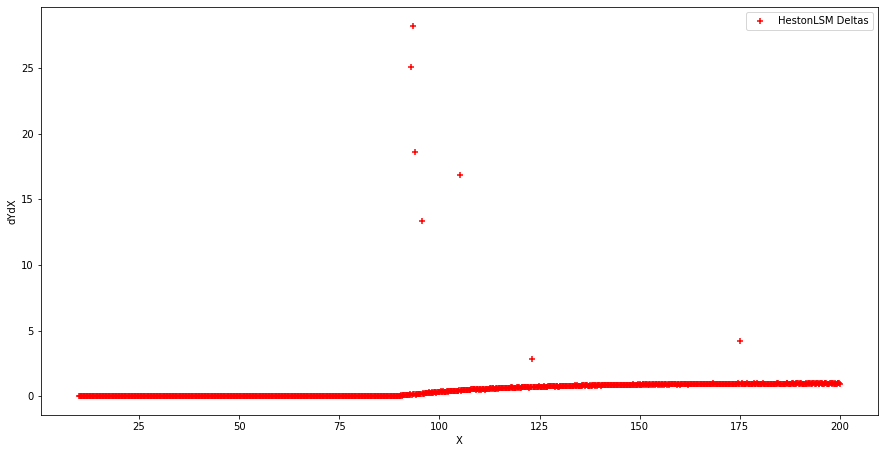

In [ ]:
# Fig 1: HestonLSM Deltas
fig1, ax1 = plt.subplots(figsize=(15, 7.5))
ax1.scatter(X, dYdX, marker="+", color="red", label='HestonLSM Deltas')
ax1.set_xlabel('X')
ax1.set_ylabel('dYdX')
ax1.legend()

After computation of the pathwise differentials using HestonLSM, we can see that a very small number of values are very far out of range. In order to be able to use "good" quality data, we decide to delete these values and therefore also delete the X the training samples (i.e. the initial states) associated with these values to preserve data homogeneity.


In [ ]:
X_modified = []
Y_modified = []
dYdX_modified = []
MC_deltas_modified = []
for i in range(len(dYdX)):
    if dYdX[i] < 1:
        X_modified.append(X[i])
        Y_modified.append(Y[i])
        dYdX_modified.append(dYdX[i])

In [ ]:
# MC Pricing Dataset
start = time.perf_counter()
MC_prices = []
MC_deltas = []
S0_list = torch.linspace(10, 200, 30)
for S0 in S0_list:
    MC_prices.append(MC_Pricing(252,100,K,B,r,T,S0.clone(), 0.1, -0.9, 0.1, 0.5, 0.1,seed))
    S0_bis = torch.tensor(S0.item(), device=device, requires_grad=True)
    MC_deltas.append(DeltaAAD(py_K, py_B, S0_bis, py_V_0, py_r, py_T, py_corr_bms, py_Kappa,
                             py_v_, py_sigma_sigma, n_steps=252, n_paths=100, seed=123))
end = time.perf_counter()
print(f"MC Pricing Data Generated ({round(end - start, 1)}s)")
MCPricing_time = round(end - start, 1)

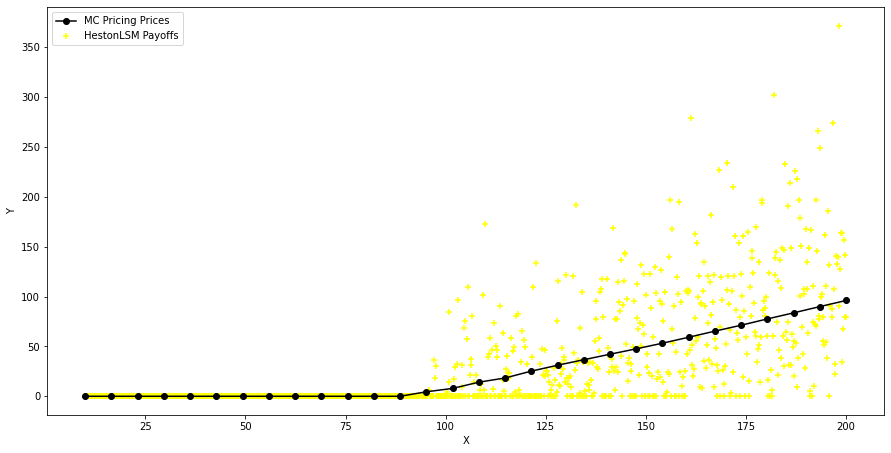

In [ ]:
# Fig 2: HestonLSM Payoffs vs MC Pricing Prices
fig2, ax2 = plt.subplots(figsize=(15, 7.5))
ax2.scatter(X_modified, Y_modified, marker="+", color="yellow", label='HestonLSM Payoffs')
ax2.plot(S0_list, MC_prices, marker="o", color="black", label='MC Pricing Prices')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()

As we can see above, the black line representing the prices computed using MC Pricing is approximately the average of the payoffs computed with HestonLSM.


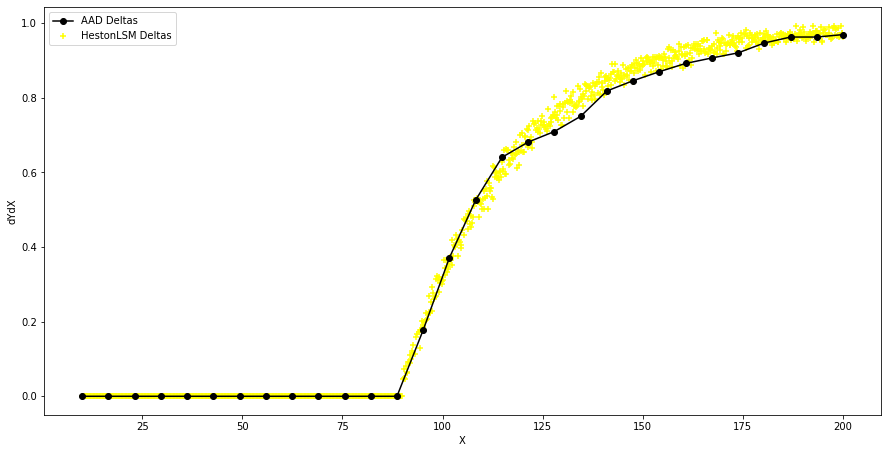

In [ ]:
# Fig 3: HestonLSM Deltas vs AAD Deltas
fig3, ax3 = plt.subplots(figsize=(15, 7.5))
ax3.scatter(X_modified, dYdX_modified, marker="+", color="yellow", label='HestonLSM Deltas')
ax3.plot(S0_list, MC_deltas, marker="o", color="black", label='AAD Deltas')
ax3.set_xlabel('X')
ax3.set_ylabel('dYdX')
ax3.legend()

When comparing the data retrieved using both methods we can see above that the results are very similar.


### 2.2 Implementation of a twin network

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function.

In our case we have :
*  4 hidden layers of 20 neurons
*  Neurons are activated using the ReLu activation function
*  The output layer is made of one neuron which should not be activated

We are going to use He/Kaiming initialization to prevent the gradient vanishing problem and also because when the ReLU activation function is used in the layers, He initialization is the recommended approach.

1. Implement a class ”Twin Network()” which inherits from the torch.nn.Module class
2. Implement a method ”predict price()” of the ”Twin Network” class
3. Implement a method ”predict price and diffs()” of the ”Twin Network” class

In [ ]:
import torch.nn as nn
import torch.nn.functional as function
import torch.optim as optim

class Twin_Network(nn.Module):
    def __init__(self, input_dimensions,nb_hidden_neurons, ouput_dimensions, seed = 123):
        super(Twin_Network, self).__init__()
        torch.manual_seed(seed)
        
        #initializing input and hidden layers
        self.input = nn.Linear(input_dimensions, nb_hidden_neurons)
        nn.init.kaiming_normal_(self.input.weight, nonlinearity='relu', mode="fan_in")
        
        self.layer_1 = nn.Linear(nb_hidden_neurons, nb_hidden_neurons)
        nn.init.kaiming_normal_(self.layer_1.weight, nonlinearity="relu", mode="fan_in")
        
        self.layer_2 = nn.Linear(nb_hidden_neurons, nb_hidden_neurons)
        nn.init.kaiming_normal_(self.layer_2.weight, nonlinearity="relu", mode="fan_in")
        
        self.layer_3 = nn.Linear(nb_hidden_neurons, nb_hidden_neurons)
        nn.init.kaiming_normal_(self.layer_3.weight, nonlinearity="relu", mode="fan_in")
        
        self.layer_4 = nn.Linear(nb_hidden_neurons, nb_hidden_neurons)
        nn.init.kaiming_normal_(self.layer_4.weight, nonlinearity="relu", mode="fan_in")
        
        self.output = nn.Linear(nb_hidden_neurons, ouput_dimensions)
        nn.init.kaiming_normal_(self.output.weight, nonlinearity='relu', mode="fan_in")
        
    def forward(self, X):
        #Neurons are activated using the ReLu activation function
        X = function.relu(self.input(X))
        X= function.relu(self.layer_1(X))
        X= function.relu(self.layer_2(X))
        X= function.relu(self.layer_3(X))
        X= function.relu(self.layer_4(X))
        X = self.output(X)
        return X

    def predict_price(self, X, mean_X, std_X, mean_Y, std_Y):
        norm_X = (X - mean_X) / std_X
        norm_X = norm_X.clone().detach().requires_grad_(True)
        norm_Y = self(norm_X).detach().numpy()
        Y = std_Y * norm_Y + mean_Y
        return Y

    def predict_price_and_diffs(self, X, mean_X, std_X, mean_Y, std_Y):
        norm_X = (X - mean_X) / std_X
        new_norm_X = norm_X.clone().detach().requires_grad_(True)
        outputs = self.forward(new_norm_X)
        recupgrad, = torch.autograd.grad(outputs, new_norm_X, grad_outputs=outputs.data.new(outputs.shape).fill_(1), retain_graph=True)
        dYdX = recupgrad.detach().numpy()
        y_scaled = outputs.detach().numpy()
        Y = mean_Y + std_Y * y_scaled
        dYdX = std_Y / std_X * dYdX
        return Y, dYdX


In [ ]:
# Example
NeuralNetwork = Twin_Network(input_dimensions = 1 ,nb_hidden_neurons = 20, ouput_dimensions = 30, seed = 123)
print(NeuralNetwork)

Twin_Network(
  (input): Linear(in_features=1, out_features=20, bias=True)
  (layer_1): Linear(in_features=20, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=30, bias=True)
)


### 2.2 Neural network training

1. Implement a function ”training()” which takes as argument the ”Neural Network()” class instantiated, the normalized training samples X, the normalized training labels Y, the normalized differential training labels dY dX, lambda j, and the number of epochs necessary to train the model. We want this function to be able to test two scenarios: (1) training the neural network only on the training samples (that is without the differential labels) and (2) training the neural network on the training samples and the differentials. Be careful, the loss must change according to the scenario we consider.1 The organisation of this function is as follows:
2. If we are in scenario (2) compute alpha =1/(1+N) , where N is the number of inputs.
3. Define MSE as the cost function
4. Define the Adam optimizer with a fix learning rate of 0.1. Keep the other defaults parameters.
5. Enter the optimisation loop : compute the predictions and the cost according the scenario you are, backropagate the gradients to optimise the network weights and biases and store the cost for each epoches.

In [ ]:

def training(NeuralNet, X_train, Y_train, dYdX_train = None, lambda_j = None, epochs = 100):
    arr_loss=[]
    # We are in Scenario (2), we store alpha here 
    if dYdX_train is not None and lambda_j is not None:
        alpha = 1.0 / (1.0 + len(X_train))
        lambda_j_torch =torch.tensor(lambda_j,device=device)
    
    #Define MSE as the cost function
    MSE = nn.MSELoss()
    
    #Define the Adam optimizer with a fix learning rate of 0.1. Keep the other defaults parameters
    optimizer = optim.Adam(NeuralNet.parameters(), lr = 0.1)

    #Enter the optimisation loop
    for epoch in range(epochs):
        step_loss = 0.0
        step_loss_train = 0.0
        step_loss_train_diff = 0.0

        outputs= NeuralNet.forward(X_train)
        loss_train = MSE(outputs, Y_train)

        if dYdX_train is not None and lambda_j is not None:
            recupgrad, = torch.autograd.grad(outputs, X_train, grad_outputs = torch.ones(outputs.shape), create_graph = True, retain_graph = True)
            loss_train_diff = MSE(lambda_j_torch * recupgrad, lambda_j_torch * dYdX_train)
            #As defined in the subject appendix
            loss = alpha * loss_train + (1-alpha) * loss_train_diff
        
        elif dYdX_train is None and lambda_j is None:
            loss = loss_train
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backpropagate the gradients
        loss.backward()
        optimizer.step()

        if epoch is not epochs-1:
            X_train.grad.data.zero_()

        # Store loss Scenario (1)
        if dYdX_train is None and lambda_j is None: 
            step_loss_train += loss_train.item()
            arr_loss.append(step_loss_train)
        
        # Store Loss Scenario (2)
        elif dYdX_train is not None and lambda_j is not None:
            step_loss_train_diff += loss_train_diff.item()
            arr_loss.append(step_loss_train_diff)

        
    return arr_loss

### 2.4 Model comparison

1. Create a training set consisting of 1000 samples using the ”HestonLSM()” function

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set the number of steps and paths
n_steps = 252
n_paths=100
seed=123
# Set the model parameters
# Convert the model parameters to PyTorch tensors and set requires_grad=True
py_v_ = torch.tensor(0.5, device=device)
py_Kappa = torch.tensor(0.1, device=device)
py_K = torch.tensor(100.0, device=device, requires_grad=True)
py_sigma_sigma = torch.tensor(0.1, device=device)
py_corr_bms = torch.tensor(-0.9, device=device)
py_r = torch.tensor(0.02, device=device, requires_grad=True)
py_S_0 = torch.tensor(100.0, device=device, requires_grad=True)
py_V_0 = torch.tensor(0.1, device=device, requires_grad=True)
py_T= torch.tensor(1.0, device=device)
py_B=torch.tensor(90, device=device)

v_ = 0.5
kappa = 0.1
sigma_sigma = 0.1
corr_bms = -0.9
r = 0.02
S0 = 100
V0 = 0.1
K=100
B=90
T=1
n_steps=252

#Create a training set consisting of 1000 samples using the ”HestonLSM()” function.
X, Y, dYdX= HestonLSM(n_steps,1000,seed,K,B,S0, V0, r, T, corr_bms, kappa,v_, sigma_sigma)


2. Normalize the data using the ”normalize data()” function on the generated dataset

In [ ]:
X_modified = []
Y_modified = []
dYdX_modified = []
MC_deltas_modified = []
for i in range(len(dYdX)):
    if dYdX[i] < 1:
        X_modified.append(X[i])
        Y_modified.append(Y[i])
        dYdX_modified.append(dYdX[i])

In [ ]:
#Normalize the data using the ”normalize data()” function on the generated dataset.
mean_X,std_X,norm_X,mean_Y,std_Y,norm_Y,norm_dYdX,lambda_j = normalize_data(X_modified,Y_modified,dYdX_modified)

3. Instantiate two networks with the ”Twin Network()” class having the following architecture: 4 hidden layers consisting of 20 neurons each. Don’t forget the seed

In [ ]:
neural_network = Twin_Network(input_dimensions = len(X_modified), nb_hidden_neurons = 20, ouput_dimensions = len(X_modified), seed = 123)
dd_neural_network = Twin_Network(input_dimensions = len(X_modified), nb_hidden_neurons =20, ouput_dimensions = len(X_modified), seed = 123)

print(neural_network)
print(dd_neural_network)

Twin_Network(
  (input): Linear(in_features=992, out_features=20, bias=True)
  (layer_1): Linear(in_features=20, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=992, bias=True)
)
Twin_Network(
  (input): Linear(in_features=992, out_features=20, bias=True)
  (layer_1): Linear(in_features=20, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=992, bias=True)
)


4. Fix the number of epochs to 100. Run the classical neural network and the differential neural network. Plot in the same figure the cost of both neural networks for all epochs. Interpret this graph.

In [ ]:
X_train = torch.FloatTensor(norm_X)
dYdX_train = torch.FloatTensor(norm_dYdX)
Y_train = torch.FloatTensor(norm_Y)

# Do not delete the gradients of the input tensor
X_train.requires_grad = True

# Train
loss_nn1=training(neural_network, X_train, Y_train)
loss_ddnn1=training(dd_neural_network, X_train, Y_train, dYdX_train, lambda_j)

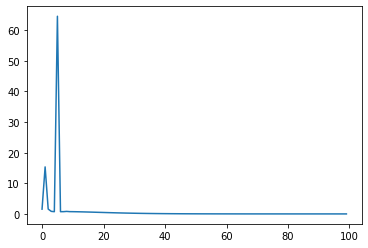

In [ ]:
plt.plot(list(range(100)),loss_nn1)

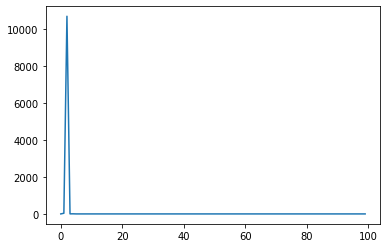

In [ ]:
plt.plot(list(range(100)),loss_ddnn1)

In order to be to correctly interpret the graphs, we chose not to plot everything in the same graph since the starting values are very far apart.
We can see that altough in both cases we start with very high values, we converge rapidly.
However, the values seem to show that the convergence is slighlty better when training the neutral network without dYdX and lambda_j. 

5. Can you imagine a simple procedure to estimate the uncertainty of the results given by a deep neural network? Implement it and give the results for both neural networks (hint: you are allowed to change the seed to answer this question).

6. (Bonus) Increase the number of samples generated by the HestonLSM() function for example : [1000, 3000, 5000, 8000,10000], and plot the corresponding cost at the end of training for each sample size. Interpret the results.

# 3 - Conclusion

1. What is the interest of having ”seeded” all the results?

In a Monte Carlo simulation, "seeding" the random number generator refers to the process of specifying a
starting value for the generator, known as the "seed." Using a seed allows you to reproduce the results of a
Monte Carlo simulation exactly. This can be useful for a number of purposes such as debugging your simula-
tion (compare the results of different runs and identify any issues that may have arisen), compare scenarios
(results with respect to different inputs) but also testing the robustness of the results (using different seeds
to see if the results vary significantly from one run to the next).
In the same way, seeding the random number generator in a neural network can be useful for multiple
reasons. Other than reproducing the same results every time, you can easily compare the results of different
runs of a neural network and see how the results vary. It also ensures that the results of a neural network
are stable and not overly sensitive to small variations in the initialization of the weights and biases. One
important thing to keep in mind when seeding a neural network is that the seed should be set before the
weights and biases are initialized. This will ensure that the initialization is consistent across different runs
of the network. In the end, seeding the random number generator can be a useful tool for understanding the
behavior of a simulation and ensuring that the results are reliable and accurate.


2. What is the advantage of using a neural network to do pricing compared
to a Monte-Carlo pricer?

Neural networks and Monte Carlo methods are both commonly used for pricing financial derivatives, but
they have different strengths and limitations. Monte Carlo methods are a type of numerical method that
can be used to solve problems by simulating random events and averaging the results. They are particularly
well-suited to pricing derivatives that have a payout that depends on the path of an underlying asset, such
as options and path-dependent exotic derivatives. However, Monte Carlo methods can be computationally
intensive, particularly for high-dimensional problems, and they can be difficult to implement accurately.
On the other hand, one advantage of using neural networks for pricing is that they can be trained to
approximate any continuous function, given enough data. This means that, in theory, a neural network
could be used to price any derivative, as long as it has a continuously-valued payout. Neural networks are
also very fast at making predictions once they have been trained, so they can be used to price derivatives in
10
real-time.Here, our Neural Network is trained before pricing which allows us to generate prices really fast.
Thus, using a neural network for pricing will depend on the specific characteristics of the derivative be-
ing priced, as well as the available computational resources and the desired level of accuracy.


3. Create a table that summarises the results of all approaches: for all models (FD, AAD, Neural network), report data generation time, pricing and greeks computation time, convergence given the number of observations/ convergence given the scheme (delta time), the uncertainty. What is the best pricer? Why?

In [ ]:
S0_list = torch.linspace(10, 200, len(X_modified))
start = time.perf_counter()
y_pred_standard, dydx_pred_standard = neural_network.predict_price_and_diffs(S0_list, mean_X,std_X, mean_Y, std_Y)
end = time.perf_counter()
print(f"NeuralNetworks Data Generated ({round(end - start, 1)}s)")
NeuralNetworks = round(end - start, 1)

NeuralNetworks Data Generated (0.0s)


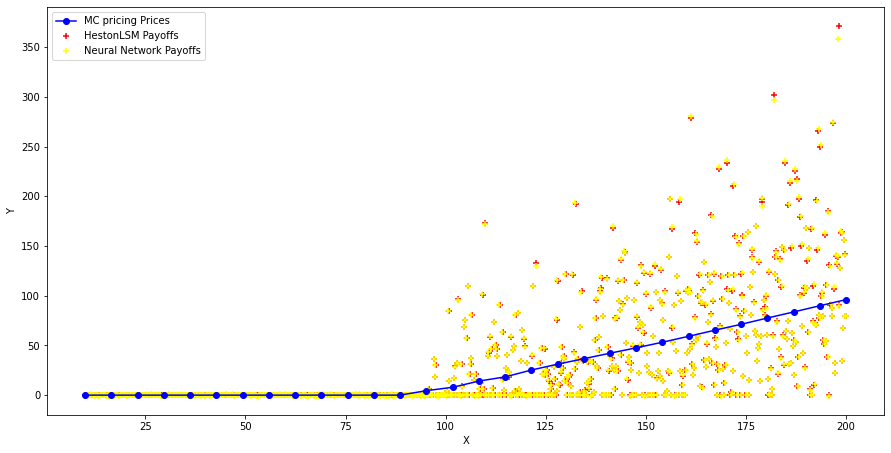

In [ ]:
# Fig 4: Pricing Function
S0_list_bis = torch.linspace(10, 200, 30)

fig4, ax4 = plt.subplots(figsize=(15, 7.5))
ax4.scatter(X_modified, Y_modified, marker="+", color="red", label='HestonLSM Payoffs')
ax4.scatter(S0_list, y_pred_standard, marker="+", color="yellow", label='Neural Network Payoffs')
ax4.plot(S0_list_bis, MC_prices, marker="o", color="blue", label='MC pricing Prices')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.legend()

In [ ]:
S0_list = torch.linspace(10, 200, len(X_modified))
dydx_pred_standard, noise = neural_network.predict_price_and_diffs(S0_list, mean_X,std_X, mean_Y, std_Y)


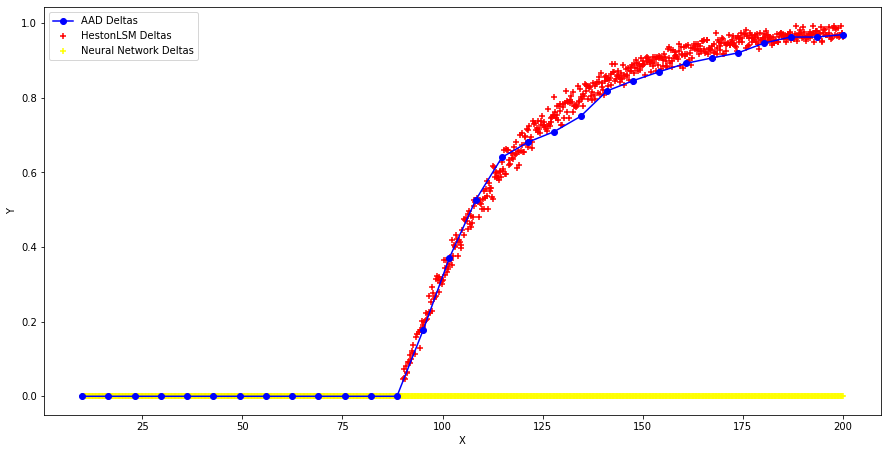

In [ ]:
# Fig 5: HestonLSM vs Neural Network vs AAD Deltas
S0_list_bis = torch.linspace(10, 200, 30)

fig5, ax5 = plt.subplots(figsize=(15, 7.5))
ax5.scatter(X_modified, dYdX_modified, marker="+", color="red", label='HestonLSM Deltas')
ax5.scatter(S0_list, dydx_pred_standard, marker="+", color="yellow", label='Neural Network Deltas')
ax5.plot(S0_list_bis, MC_deltas, marker="o", color="blue", label='AAD Deltas')
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.legend()


4. Give the advantages and drawbacks of all the techniques presented above. Finite difference method (FD, bumping) :
On one hand, This technique is used extensively when it comes to pricing a wide range of options, including exotic options, or even options on multi-dimensional underlying assets. This method is easy to implement and does not require advanced mathematical (Monte Carlo pricing) or programming skills (Pytorch python library). It is robust and can handle complex payoffs and boundary conditions. In the end, this method provides a good benchmark for other numerical methods (as we did along this project) and can be used to validate more sophisticated methods. On the other hand, bumping can be relatively slow for pricing complex options or options on multi-dimensional underlying assets. Through this method, one needs to use models (such as Monte Carlo here) where one makes the assumption of a constant volatility, which is not realistic. Finally, this method is not accurate deep ITM or OTM options. Automatic adjoint differentiation (AAD) This method is particularly useful for option pricing, as it allows for the fast and accurate computation of the Greeks. Computing the gradient of a function can be much faster than other methods, especially for large and complex functions. It can also be more accurate than other methods (such as FD), as it avoids truncation mistakes. It is also really easy to implement, which can save time and reduce the risk of errors. Despite these advantages, AAD methods can be prone to numerical instability, particularly when used with complex models or high-dimensional problems. Also, from a more practical standpoint, as the intermediate values needed to compute the gradient are not directly accessible, it can be difficult to debug problems. Neural Network: Neural networks can capture complex, non-linear relationships in option prices and underlying assets, which can be difficult to model with traditional statistical techniques. This method also allows handling large amounts of data, making them well-suited to the high-dimensional nature of option pricing problems. It can be really helpful to handle noisy or incomplete data, making this method robust to imperfections in market data. On the other hand, this method requires a large amount of data to be effective, and option prices may not be available for a large number of underlying assets to train the network effectively. Com- putationally speaking, it can be really intensive to train the network appropriately. Neural networks are also quite sensitive to initial conditions which means it may require extensive adjustments to achieve good performance. Finally, as for any Machine Learning algorithm, there are overfitting risks, where the neural network performs well on the training data but poorly on testing data.